In [1]:
# pip install yellowbrick

In [2]:
# pip install Flask

In [3]:
# pip install tabulate

In [4]:
import os
import zipfile
import requests
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Set your Kaggle API credentials
kaggle_username = "yujata"
kaggle_key = "9242ecee1e5f52d323ef6aa903f216e5"

# Set the dataset URL
dataset_url = "https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset"

# Set the dataset name (change if necessary)
dataset_name = "amazon-sales-dataset"

# Set the path where you want to save the dataset
download_path = "/Users/yujata/Projects/"

# Create the Kaggle configuration file
kaggle_json_path = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
kaggle_json_content = '{"username":"'+kaggle_username+'","key":"'+kaggle_key+'"}'

os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
with open(kaggle_json_path, 'w') as f:
    f.write(kaggle_json_content)

# Download the dataset using Kaggle API
command = f'kaggle datasets download -d karkavelrajaj/{dataset_name} -p {download_path}'
os.system(command)

# Extract the downloaded zip file
with zipfile.ZipFile(os.path.join(download_path, f'{dataset_name}.zip'), 'r') as zip_ref:
    zip_ref.extractall(download_path)

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(os.path.join(download_path, 'amazon.csv'))

amazon-sales-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
print(data.columns)
print("------------------------------------------------------")
print("Total Records : ",data.shape)
print("------------------------------------------------------")
print("DDL")
print(data.info())
print("------------------------------------------------------")
print("Missing Records")
print(data.isnull().sum())
print("------------------------------------------------------")
print("Percentage of missing records")
print(data.isnull().sum()/len(data)*100)
print("------------------------------------------------------")
print("Unique Records")
print(data[["product_id","product_name","category","category","user_id","user_name"]].nunique())

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')
------------------------------------------------------
Total Records :  (1465, 16)
------------------------------------------------------
DDL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_coun

In [7]:
## Data Cleaning

In [8]:
## Clean the numerical columns

In [9]:
data['actual_price'] = data['actual_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)
data['discounted_price'] = data['discounted_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)
data['discount_percentage'] = data['discount_percentage'].astype(str).str.replace('%', '').astype(int)
data['rating_count'] = pd.to_numeric(data['rating_count'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
data['rating'] = pd.to_numeric(data['rating'].str.replace('|', ''), errors='coerce').astype(float)

# print 
data.head()

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_18417/3916458841.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['rating'] = pd.to_numeric(data['rating'].str.replace('|', ''), errors='coerce').astype(float)


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64,4.2,24269,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43,4.0,43994,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90,3.9,7928,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53,4.2,94363,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61,4.2,16905,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [10]:
### Splitting and cleaning the Category column

In [11]:
# Create a new dataframe with the split categories
data_categories = data['category'].str.split('|', expand=True)

# Rename the columns for clarity
data_categories.columns = [f'category_{i+1}' for i in range(data_categories.shape[1])]

# Concatenate the original dataframe with the new categories dataframe
data = pd.concat([data, data_categories], axis=1)

# Drop the original 'category' column if you no longer need it
data = data.drop('category', axis=1)
data.columns

Index(['product_id', 'product_name', 'discounted_price', 'actual_price',
       'discount_percentage', 'rating', 'rating_count', 'about_product',
       'user_id', 'user_name', 'review_id', 'review_title', 'review_content',
       'img_link', 'product_link', 'category_1', 'category_2', 'category_3',
       'category_4', 'category_5', 'category_6', 'category_7'],
      dtype='object')

In [12]:
print("Unique values in Product Category columns")
print("------------------------------------------------------")
print(data[['category_1', 'category_2', 'category_3',
       'category_4', 'category_5', 'category_6', 'category_7']].nunique())

Unique values in Product Category columns
------------------------------------------------------
category_1      9
category_2     29
category_3     71
category_4    136
category_5     56
category_6     14
category_7      7
dtype: int64


## EDA

In [13]:
data.columns

Index(['product_id', 'product_name', 'discounted_price', 'actual_price',
       'discount_percentage', 'rating', 'rating_count', 'about_product',
       'user_id', 'user_name', 'review_id', 'review_title', 'review_content',
       'img_link', 'product_link', 'category_1', 'category_2', 'category_3',
       'category_4', 'category_5', 'category_6', 'category_7'],
      dtype='object')

In [14]:
## Find unique product categories from all the columns abd find total of discounted and actual price

In [15]:
unique_categories = set(data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7']].values.flatten())
agg_columns = ['discounted_price', 'actual_price']

# Initialize an empty DataFrame to store aggregated results
agg_data = pd.DataFrame(index=list(unique_categories), columns=agg_columns)

# Iterate over unique categories and aggregate values
for category in unique_categories:
    category_mask = (data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7']] == category).any(axis=1)
    category_data = data[category_mask]
    agg_data.loc[category] = category_data[agg_columns].sum()

# Convert columns to numeric for sorting
agg_data[agg_columns] = agg_data[agg_columns].apply(pd.to_numeric)

# Sort the DataFrame by 'actual_price' and 'discounted_price' in descending order
agg_data_sorted_price = agg_data.sort_values(by=['actual_price', 'discounted_price'], ascending=False)

# Reset the index for proper formatting
agg_data_sorted_price.reset_index(inplace=True)

# Create a new DataFrame with desired columns
agg_data_sorted_price_df = pd.DataFrame({
    'Category': agg_data_sorted_price['index'],
    'Actual_Price': agg_data_sorted_price['actual_price'],
    'Discounted_Price': agg_data_sorted_price['discounted_price']
})

# Display the aggregated and sorted data with the desired columns
agg_data_sorted_price_df

,Category,Actual_Price,Discounted_Price
0,Electronics,5326966.0,3138057.00
1,"HomeTheater,TV&Video",2792181.0,1685954.00
2,Televisions,2620347.0,1608017.00
3,SmartTelevisions,2528369.0,1564932.00
4,Home&Kitchen,1864609.0,1044115.81
...,...,...,...
313,Copy&PrintingPaper,99.0,99.00
314,Pencils,99.0,99.00
315,ColouredPaper,99.0,99.00
316,WoodenPencils,99.0,99.00


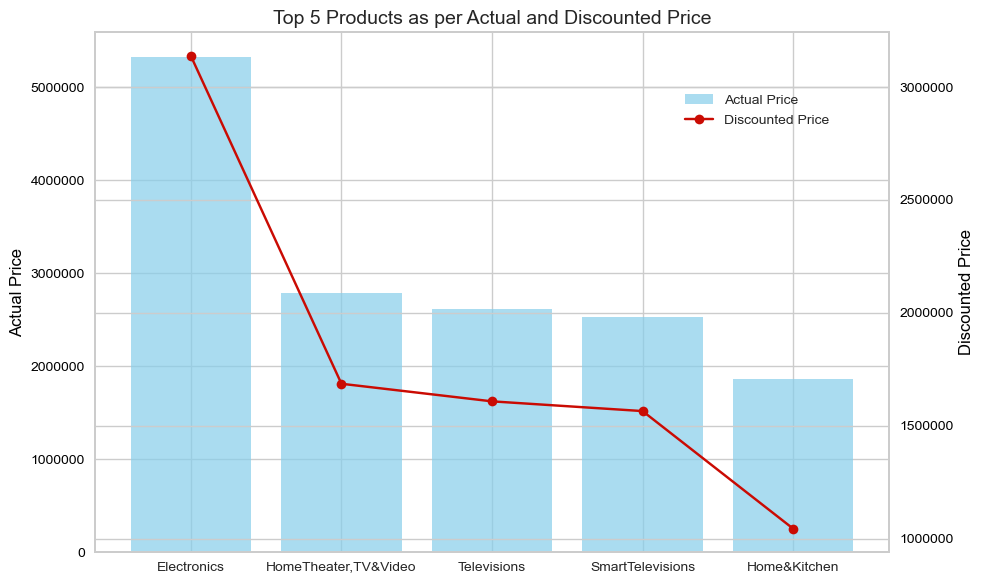

-----------------------------------------------------------------


,Category,Actual_Price,Discounted_Price
49,TraditionalLaptops,59890.0,37247.0
29,Accessories,149674.0,59704.0
87,DomeCameras,25488.0,13786.0
93,Kettle&ToasterSets,23037.0,12625.0
143,WaterPurifierAccessories,8179.0,4505.0
95,"Coffee,Tea&Espresso",20332.0,13932.0
149,MousePads,7679.0,2949.0
6,Smartphones&BasicMobiles,1419754.0,1086799.0
243,RechargeableBatteries,1348.0,1128.0
238,PowerAccessories,1499.0,1289.0


In [16]:
top_05_products = agg_data_sorted_price_df.head(5)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for 'actual_price'
ax1.bar(top_05_products["Category"], top_05_products['Actual_Price'], color='skyblue', alpha=0.7, label='Actual Price')
ax1.set_xlabel('')
ax1.set_ylabel('Actual Price', color='black',fontsize=12)
ax1.tick_params('y', colors='black')

# Create a second y-axis for 'discounted_price'
ax2 = ax1.twinx()
ax2.plot(top_05_products["Category"], top_05_products['Discounted_Price'], color='r', marker='o', label='Discounted Price')
ax2.set_ylabel('Discounted Price', color='black',fontsize=12)
ax2.tick_params('y', colors='black')

# Use FuncFormatter to format y-axis values without scientific notation and rounded to 0 decimal places
formatter = FuncFormatter(lambda x, _: format(x, '.0f'))
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Title and legend
plt.title('Top 5 Products as per Actual and Discounted Price',fontsize=14)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Show the plot
plt.show()
print("-----------------------------------------------------------------")
agg_data_sorted_price_df.sample(20)

In [17]:
print("""
# Top 20 Products by Pricing :
## Following insights highlight the diverse pricing strategies and competitive dynamics across different product/n  categories.
1. "Mobile Accessories" exhibit significant price differences, indicating a competitive market or promotional/n    activities.
2. The "Electronics" category, with the highest actual and discounted prices, stands out as a major revenue driver.
3. "Bluetooth Adapters" show a noticeable discount, suggesting competition or strategic pricing.
4. "Projectors" are discounted, possibly to stimulate sales or respond to market demand.
5. "Inkjet Printers" have a moderate discount, implying a balance between price sensitivity and product value.
6. "Screen Protectors" have a substantial discount, possibly targeting price-conscious consumers or encouraging/n   bulk purchases.
7. "Gaming Keyboards" display a notable discount, indicating a competitive market or a strategy to attract price-/n  conscious gamers.
8. "USB to USB Adapters" showcase a significant discount, likely aimed at boosting sales.
9. "Outdoor Speakers" have a considerable discount, signaling potential price sensitivity or a market strategy.
10. "Wet Grinders" exhibit a discount, suggesting price sensitivity in this category. Further analysis is needed to understand market dynamics.
""")


# Top 20 Products by Pricing :
## Following insights highlight the diverse pricing strategies and competitive dynamics across different product/n  categories.
1. "Mobile Accessories" exhibit significant price differences, indicating a competitive market or promotional/n    activities.
2. The "Electronics" category, with the highest actual and discounted prices, stands out as a major revenue driver.
3. "Bluetooth Adapters" show a noticeable discount, suggesting competition or strategic pricing.
4. "Projectors" are discounted, possibly to stimulate sales or respond to market demand.
5. "Inkjet Printers" have a moderate discount, implying a balance between price sensitivity and product value.
6. "Screen Protectors" have a substantial discount, possibly targeting price-conscious consumers or encouraging/n   bulk purchases.
7. "Gaming Keyboards" display a notable discount, indicating a competitive market or a strategy to attract price-/n  conscious gamers.
8. "USB to USB Adapters" showcase

In [18]:
unique_categories = set(data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7']].values.flatten())
agg_columns = ['rating', 'rating_count']

# Initialize an empty DataFrame to store aggregated results
agg_data = pd.DataFrame(index=list(unique_categories), columns=agg_columns)

# Iterate over unique categories and aggregate values
for category in unique_categories:
    category_mask = (data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7']] == category).any(axis=1)
    category_data = data[category_mask]
    agg_data.loc[category] = category_data[agg_columns].mean()
    
# Convert columns to numeric for sorting
agg_data[agg_columns] = agg_data[agg_columns].apply(pd.to_numeric)

# Sort the DataFrame by 'actual_price' and 'discounted_price' in descending order
agg_data_sorted_rating = agg_data.sort_values(by=['rating', 'rating_count' ], ascending=False)

# Reset the index for proper formatting
agg_data_sorted_rating.reset_index(inplace=True)

# Create a new DataFrame with desired columns
agg_data_sorted_rating = pd.DataFrame({
    'Category': agg_data_sorted_rating['index'],
    'Avg_Rating': agg_data_sorted_rating['rating'],
    'Avg_Rating_Count': agg_data_sorted_rating['rating_count']
})

# Display the aggregated data
agg_data_sorted_rating

,Category,Avg_Rating,Avg_Rating_Count
0,Tablets,4.6,2886.0
1,Memory,4.5,26194.0
2,PowerLANAdapters,4.5,22420.0
3,SurgeProtectors,4.5,20668.0
4,PowerAccessories,4.5,20668.0
...,...,...,...
313,3DGlasses,3.5,621.0
314,DustCovers,3.4,10462.5
315,CoffeeGrinders,3.3,478.0
316,ElectricGrinders,3.3,478.0


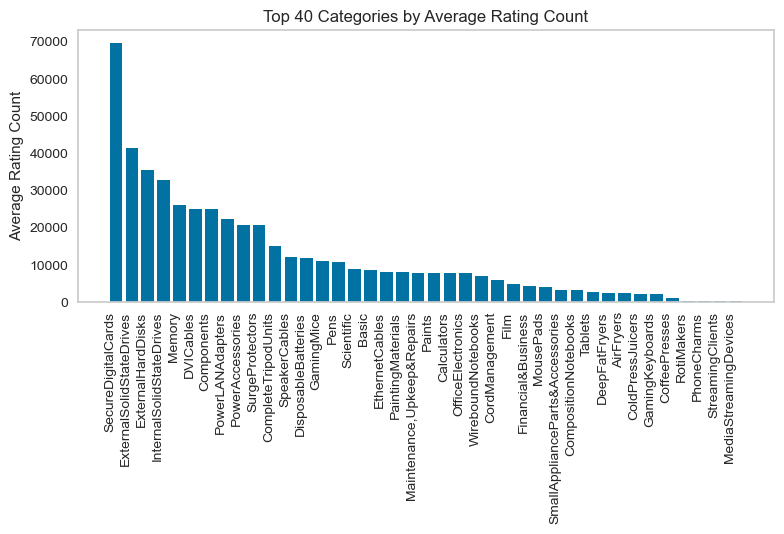

-----------------------------------------------------------------
                           Category  Avg_Rating_Count
20               SecureDigitalCards      69585.000000
21         ExternalSolidStateDrives      41398.000000
22                ExternalHardDisks      35518.666667
34         InternalSolidStateDrives      32823.000000
1                            Memory      26194.000000
23                        DVICables      25177.000000
36                       Components      25005.000000
2                  PowerLANAdapters      22420.000000
4                  PowerAccessories      20668.000000
3                   SurgeProtectors      20668.000000
24              CompleteTripodUnits      15137.000000
25                    SpeakerCables      12091.000000
19              DisposableBatteries      12007.000000
35                       GamingMice      11011.333333
26                             Pens      10718.000000
14                       Scientific       8969.500000
5               

In [19]:
# Selecting the top 40 categories
top_40_categories = agg_data_sorted_rating.head(40).sort_values(by='Avg_Rating_Count', ascending=False)

# Plotting the bar chart
plt.bar(top_40_categories['Category'], top_40_categories['Avg_Rating_Count'], color='b')
plt.xlabel('')
plt.ylabel('Average Rating Count')
plt.title('Top 40 Categories by Average Rating Count')
plt.xticks(rotation=90, ha='right')  
plt.tight_layout()
plt.grid(False)

plt.show()
print("-----------------------------------------------------------------")
print(top_40_categories[["Category","Avg_Rating_Count"]])

In [20]:
print("The provided data lists top product categories based on average rating counts, offering insights and potential strategies for each:")
print("\n1. Popular Storage Devices:")
print("   - Products like SD cards, external SSDs, and HDDs have high ratings.")
print("   - Strategy: Emphasize reliability, storage capacity, and compatibility.")
print("\n2. Computer Components:")
print("   - Internal SSDs and memory (RAM) show a demand for computer upgrades.")
print("   - Strategy: Focus on speed, compatibility, and market towards gaming and productivity.")
print("\n3. Connectivity Accessories:")
print("   - DVI cables and Ethernet cables are essential for displays and networking.")
print("   - Strategy: Ensure compatibility, emphasize durability, and target tech-savvy users.")
print("\n4. Power and Protection:")
print("   - PowerLAN adapters, surge protectors, and batteries are in demand.")
print("   - Strategy: Highlight safety features, energy efficiency, and emphasize longevity.")
print("\n5. Gaming Peripherals:")
print("   - Gaming mice and keyboards have high ratings.")
print("   - Strategy: Focus on customization, ergonomic design, and precision for competitive gaming.")
print("\n6. Office and Creative Supplies:")
print("   - Pens, wirebound notebooks, and painting materials are popular.")
print("   - Strategy: Emphasize quality, durability, and customization options for businesses or creatives.")
print("\n7. Maintenance and Repair Products:")
print("   - Categories related to maintenance and repairs are sought after.")
print("   - Strategy: Offer comprehensive maintenance kits, guides, and durable products.")
print("\n8. Specialized Appliances:")
print("   - Categories like air fryers and deep fat fryers have decent ratings.")
print("   - Strategy: Market features, energy efficiency, and cooking capabilities.")
print("\n9. Niche Electronics:")
print("   - Categories like calculators, office electronics, and scientific items are diverse.")
print("   - Strategy: Analyze subcategories, tailor marketing efforts, and target specific customer preferences.")
print("\n10. Diversified Offerings:")
print("    - Categories like film, financial and business products, tablets, and streaming devices show diversity.")
print("    - Strategy: Tailor marketing strategies based on the specific offerings within each category.")
print("\nThese insights provide a roadmap for developing targeted marketing strategies within each category, considering product features, customer preferences, and market trends. Further analysis is recommended for a more detailed and nuanced approach.")

The provided data lists top product categories based on average rating counts, offering insights and potential strategies for each:

1. Popular Storage Devices:
   - Products like SD cards, external SSDs, and HDDs have high ratings.
   - Strategy: Emphasize reliability, storage capacity, and compatibility.

2. Computer Components:
   - Internal SSDs and memory (RAM) show a demand for computer upgrades.
   - Strategy: Focus on speed, compatibility, and market towards gaming and productivity.

3. Connectivity Accessories:
   - DVI cables and Ethernet cables are essential for displays and networking.
   - Strategy: Ensure compatibility, emphasize durability, and target tech-savvy users.

4. Power and Protection:
   - PowerLAN adapters, surge protectors, and batteries are in demand.
   - Strategy: Highlight safety features, energy efficiency, and emphasize longevity.

5. Gaming Peripherals:
   - Gaming mice and keyboards have high ratings.
   - Strategy: Focus on customization, ergonomic d

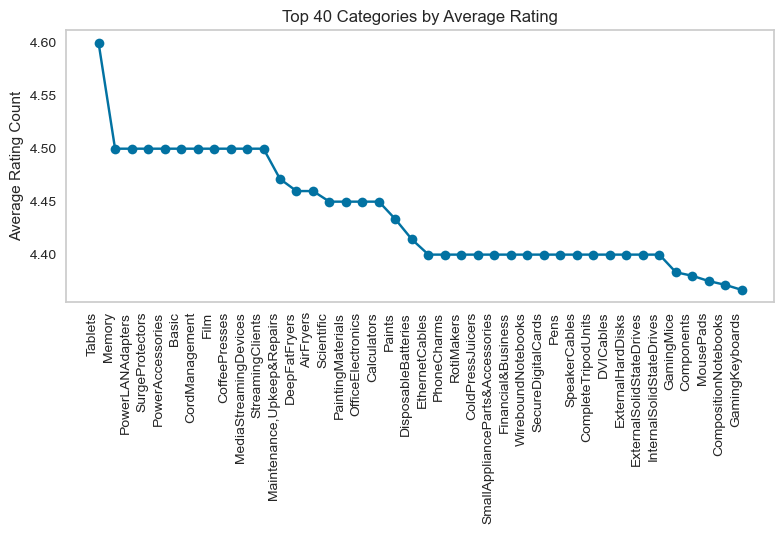

-----------------------------------------------------------------
                           Category  Avg_Rating
0                           Tablets    4.600000
1                            Memory    4.500000
2                  PowerLANAdapters    4.500000
3                   SurgeProtectors    4.500000
4                  PowerAccessories    4.500000
5                             Basic    4.500000
6                    CordManagement    4.500000
7                              Film    4.500000
8                     CoffeePresses    4.500000
9             MediaStreamingDevices    4.500000
10                 StreamingClients    4.500000
11       Maintenance,Upkeep&Repairs    4.471429
13                    DeepFatFryers    4.460000
12                        AirFryers    4.460000
14                       Scientific    4.450000
15                PaintingMaterials    4.450000
16                OfficeElectronics    4.450000
17                      Calculators    4.450000
18                    

In [21]:
# Selecting the top 40 categories
top_40_categories = agg_data_sorted_rating.head(40).sort_values(by='Avg_Rating', ascending=False)

# Plotting the bar chart
plt.plot(top_40_categories['Category'], top_40_categories['Avg_Rating'], marker='o', linestyle='-', color='b')
plt.xlabel('')
plt.ylabel('Average Rating Count')
plt.title('Top 40 Categories by Average Rating')
plt.xticks(rotation=90, ha='right')  
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()
print("-----------------------------------------------------------------")
print(top_40_categories[["Category","Avg_Rating"]])

In [22]:
print("Highly Rated Categories:")
print("\nThe top-rated categories, with an average rating of 4.5 or above, include Tablets, Memory, PowerLAN Adapters, Power Accessories, Surge Protectors, Basic, Cord Management, Film, Coffee Presses, Streaming Clients, and Media Streaming Devices. Products in these categories are consistently well-received by customers.")

print("\nDiverse Range of Products:")
print("\nThe highly-rated categories encompass a diverse range of products, from electronic devices like tablets and power accessories to everyday items like coffee presses and cord management solutions. This suggests that customer satisfaction is high across various product types.")

print("\nFocus on Technology and Connectivity:")
print("\nCategories such as PowerLAN Adapters, Power Accessories, Surge Protectors, Streaming Clients, and Media Streaming Devices indicate a focus on technology, connectivity, and power management. This aligns with the increasing importance of these features in modern consumer electronics.")

print("\nMaintenance and Repairs:")
print("\nThe \"Maintenance, Upkeep & Repairs\" category, although slightly lower in average rating compared to the top-rated ones, still enjoys a high average rating of 4.47. This suggests that customers are generally satisfied with maintenance and repair-related products.")

print("\nKitchen Appliances:")
print("\nAir Fryers and Deep Fat Fryers, both related to kitchen appliances, have high average ratings (4.46). This indicates positive customer experiences with these specific types of cooking devices.")

print("\nArt and Office Supplies:")
print("\nCategories such as Scientific, Painting Materials, Office Electronics, and Calculators suggest that customers are satisfied with products related to art, office supplies, and scientific equipment.")

print("\nElectronics Accessories:")
print("\nVarious electronics accessories, including Ethernet Cables, Phone Charms, Speaker Cables, DVI Cables, and Secure Digital Cards, have average ratings of 4.4 or above. This reflects positive sentiment towards accessories and cables in the electronics category.")

print("\nGaming Peripherals:")
print("\nGaming-related categories like Gaming Mice, Components, Mouse Pads, Composition Notebooks, and Gaming Keyboards also have respectable average ratings, indicating that customers are satisfied with gaming peripherals and accessories.")

print("\nConsistent Ratings:")
print("\nMany categories have consistent average ratings, which suggests a certain level of quality and customer satisfaction across a broad spectrum of products.")

Highly Rated Categories:

The top-rated categories, with an average rating of 4.5 or above, include Tablets, Memory, PowerLAN Adapters, Power Accessories, Surge Protectors, Basic, Cord Management, Film, Coffee Presses, Streaming Clients, and Media Streaming Devices. Products in these categories are consistently well-received by customers.

Diverse Range of Products:

The highly-rated categories encompass a diverse range of products, from electronic devices like tablets and power accessories to everyday items like coffee presses and cord management solutions. This suggests that customer satisfaction is high across various product types.

Focus on Technology and Connectivity:

Categories such as PowerLAN Adapters, Power Accessories, Surge Protectors, Streaming Clients, and Media Streaming Devices indicate a focus on technology, connectivity, and power management. This aligns with the increasing importance of these features in modern consumer electronics.

Maintenance and Repairs:

The "M

## K- MEANS CLUSTERUING FOR CUSTOMER SEGMENATATION

In [23]:
# Drop non-numeric columns
non_numeric_columns = ['product_id', 'product_name', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link','category_1', 'category_2', 'category_3', "about_product",'category_4', 'category_5', 'category_6', 'category_7']
            
df_clustering_subset = data.drop(non_numeric_columns, axis=1)
df_clustering_subset

,discounted_price,actual_price,discount_percentage,rating,rating_count,user_id
0,399.0,1099.0,64,4.2,24269,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB..."
1,199.0,349.0,43,4.0,43994,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX..."
2,199.0,1899.0,90,3.9,7928,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ..."
3,329.0,699.0,53,4.2,94363,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S..."
4,154.0,399.0,61,4.2,16905,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH..."
...,...,...,...,...,...,...
1460,379.0,919.0,59,4.0,1090,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U..."
1461,2280.0,3045.0,25,4.1,4118,"AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH..."
1462,2219.0,3080.0,28,3.6,468,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ..."
1463,1399.0,1890.0,26,4.0,8031,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS..."


                     discounted_price  actual_price  discount_percentage  \
discounted_price             1.000000      0.961915             0.242412   
actual_price                 0.961915      1.000000             0.118098   
discount_percentage          0.242412      0.118098             1.000000   
rating                       0.120337      0.121642             0.155375   
rating_count                 0.027010      0.035890             0.010868   

                       rating  rating_count  
discounted_price     0.120337      0.027010  
actual_price         0.121642      0.035890  
discount_percentage  0.155375      0.010868  
rating               1.000000      0.101584  
rating_count         0.101584      1.000000  
-----------------------------------------------------------------


/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_18417/3386855522.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_clustering_subset.corr().abs()


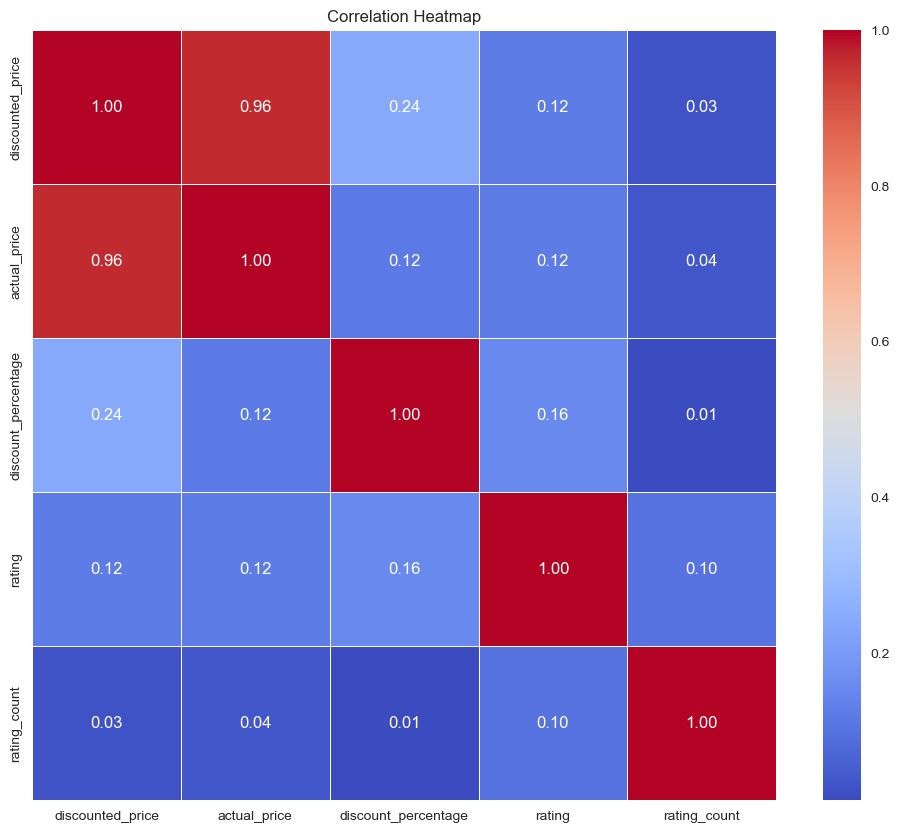

In [24]:
correlation_matrix = df_clustering_subset.corr().abs()
print(correlation_matrix)
print("-----------------------------------------------------------------")
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [25]:
print("The correlation matrix reveals a high correlation (approximately 0.96) between discounted_price and actual_price." 
      "  In K-means clustering, such high correlation introduces redundancy, hindering cluster separation.                   To mitigate this,actual_price is dropped, considering its slightly higher correlation. ")

The correlation matrix reveals a high correlation (approximately 0.96) between discounted_price and actual_price.  In K-means clustering, such high correlation introduces redundancy, hindering cluster separation.                   To mitigate this,actual_price is dropped, considering its slightly higher correlation. 


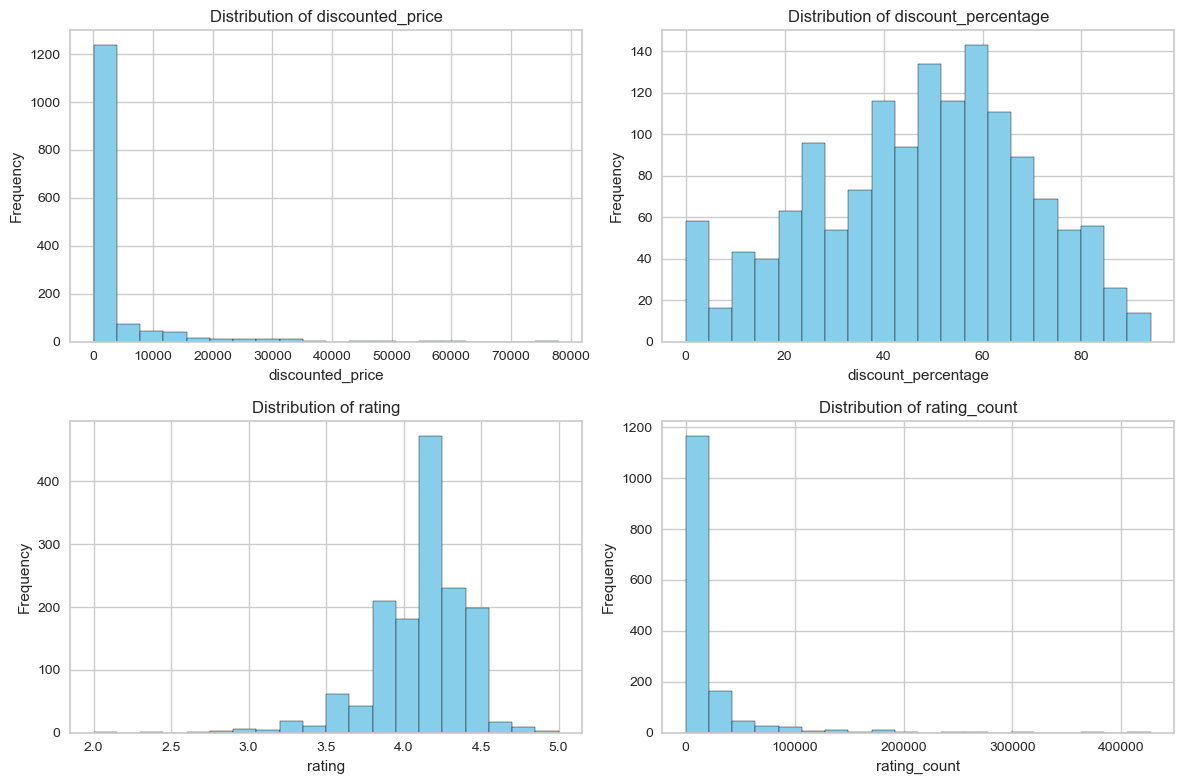

In [26]:
selected_features = ['discounted_price', 'discount_percentage', 'rating', 'rating_count']

# Set the number of columns and rows for subplots
num_cols = 2
num_rows = (len(selected_features) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array to make it easier to index
axes = axes.flatten()

# Plot histograms/distribution plots for each selected feature
for i, feature in enumerate(selected_features):
    axes[i].hist(df_clustering_subset[feature], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

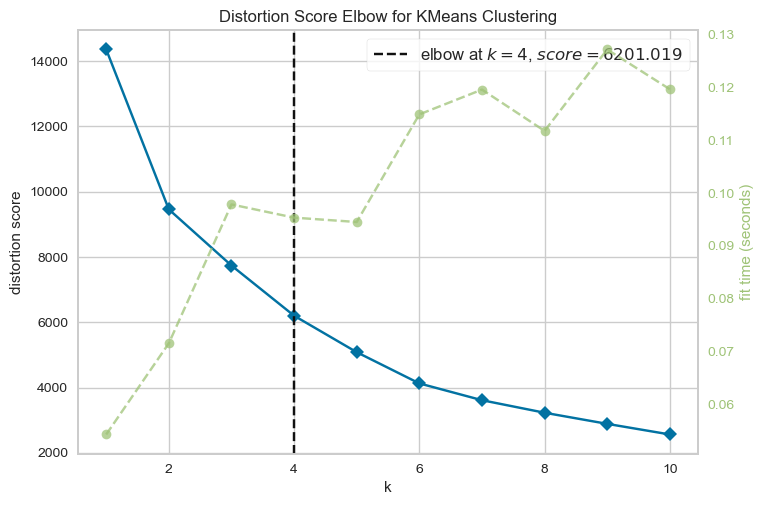

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
selected_features = ['discounted_price', "discount_percentage", 'rating', 'rating_count']

# Combine selected features
X = df_clustering_subset[selected_features] 
# Drop missing values from both X and df_clustering_subset
X = X.dropna().reset_index(drop=True)
df_clustering_subset = df_clustering_subset.loc[X.index].reset_index(drop=True)


numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

# Create preprocessor for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ])

# Apply K-means clustering for a range of clusters 
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])
    pipeline.fit(X)
    inertia.append(kmeans.inertia_)
    
# Apply K-means clustering and use Yellowbrick for elbow visualization
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 11))

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])
visualizer.fit(pipeline.fit_transform(X))
visualizer.show()

In [28]:
print("An elbow point is identified where the rate of decrease in the distortion score slows down")
print("In this specific case, the distortion score decreases notably up to k=4, and the decrease becomes less pronounced for higher values of k.")
print("Therefore, based on the elbow method analysis, the optimal number of clusters for the given data appears to be 4.")

An elbow point is identified where the rate of decrease in the distortion score slows down
In this specific case, the distortion score decreases notably up to k=4, and the decrease becomes less pronounced for higher values of k.
Therefore, based on the elbow method analysis, the optimal number of clusters for the given data appears to be 4.


In [29]:
# Apply K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])
df_clustering_subset['cluster'] = pipeline.fit_predict(X)

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### MODEL ASSESSMENT

In [30]:
# Silhouette Score
silhouette_avg = silhouette_score(X, df_clustering_subset['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index
db_index = davies_bouldin_score(X, df_clustering_subset['cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(X, df_clustering_subset['cluster'])
print(f"Calinski-Harabasz Index: {ch_index}")

Silhouette Score: 0.04384534587994817
Davies-Bouldin Index: 7.668411182185934
Calinski-Harabasz Index: 976.0090744462057


In [31]:
## Hyperparameter tuning to fine tune the clustering model

In [32]:
# Create K-means pipeline
kmeans = KMeans(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans)
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [3, 4, 5, 6],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
}

# Create silhouette scorer
silhouette_scorer = make_scorer(silhouette_score)

# Use GridSearchCV with silhouette scorer
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)


# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Results : 
# Best Parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 100, 'kmeans__n_clusters': 3}

# Update the pipeline with the best parameters
pipeline.set_params(**best_params)

# Fit the model with the updated pipeline
df_clustering_subset['cluster_new'] = pipeline.fit_predict(X)

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

Best Parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 100, 'kmeans__n_clusters': 3}


In [33]:
# Silhouette Score
silhouette_avg = silhouette_score(X, df_clustering_subset['cluster_new'])
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index
db_index = davies_bouldin_score(X, df_clustering_subset['cluster_new'])
print(f"Davies-Bouldin Index: {db_index}")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(X, df_clustering_subset['cluster_new'])
print(f"Calinski-Harabasz Index: {ch_index}")

Silhouette Score: 0.08925233100371854
Davies-Bouldin Index: 3.387926513476769
Calinski-Harabasz Index: 1399.4203304626028


In [34]:
# Metrics values
silhouette_score_value = 0.08925233100371854
davies_bouldin_index_value = 3.387926513476769
calinski_harabasz_index_value = 1399.4203304626028

# Print statements with corrected formatting
print(f"The silhouette score suggests that the clusters are reasonably well-separated and defined: {silhouette_score_value}")
print(f"The Davies-Bouldin index indicates moderate compactness and separation between clusters: {davies_bouldin_index_value}")
print(f"The Calinski-Harabasz index suggests that the clustering performance is relatively good, with distinct and well-   separated clusters: {calinski_harabasz_index_value}")

The silhouette score suggests that the clusters are reasonably well-separated and defined: 0.08925233100371854
The Davies-Bouldin index indicates moderate compactness and separation between clusters: 3.387926513476769
The Calinski-Harabasz index suggests that the clustering performance is relatively good, with distinct and well-   separated clusters: 1399.4203304626028


### MODELLING RESULTS ANALYSIS

In [35]:
# Aggregate by cluster and calculate counts and sums
aggregated_data = df_clustering_subset.groupby('cluster_new').agg(
    count=('user_id', 'count'),
    sum_discounted_price=('discounted_price', 'sum'),
    sum_discount_percentage=('discount_percentage', 'sum'),
    sum_rating=('rating', 'sum'),
    sum_rating_count=('rating_count', 'sum')
).reset_index()
aggregated_data

,cluster_new,count,sum_discounted_price,sum_discount_percentage,sum_rating,sum_rating_count
0,0,886,1000800.29,52682,3574.8,10576861
1,1,536,3515317.14,15171,2243.5,6866312
2,2,42,59600.00,1993,174.8,9316217


In [36]:
# Cluster 1: High-Value Shoppers
print("1. High-Value Shoppers:")
print("- This cluster consists of customers with a significant sum of discounted prices, indicating substantial purchases with discounts.")
print("- The high count suggests a large customer base, crucial for marketing and promotional activities.")
print("- The sum of ratings and rating count are both relatively high, indicating frequent engagement and product/service ratings.")
print()

# Cluster 0: Frequent Discount Seekers
print("2. Frequent Discount Seekers:")
print("- This cluster represents customers who frequently avail discounts.")
print("- The large count suggests a broad audience, making them a key segment for marketing and retention strategies.")
print("- The substantial sum of discounted prices reflects the economic significance of this customer segment.")
print()

# Cluster 2: Premium Customers
print("3. Premium Customers:")
print("- This cluster includes customers with a low count but a high sum of discounted prices, indicating higher-value purchases.")
print("- The relatively high sum of ratings suggests active engagement and feedback from this smaller segment.")
print("- The lower sum of discount percentages indicates a potential willingness to pay a premium for quality.")

1. High-Value Shoppers:
- This cluster consists of customers with a significant sum of discounted prices, indicating substantial purchases with discounts.
- The high count suggests a large customer base, crucial for marketing and promotional activities.
- The sum of ratings and rating count are both relatively high, indicating frequent engagement and product/service ratings.

2. Frequent Discount Seekers:
- This cluster represents customers who frequently avail discounts.
- The large count suggests a broad audience, making them a key segment for marketing and retention strategies.
- The substantial sum of discounted prices reflects the economic significance of this customer segment.

3. Premium Customers:
- This cluster includes customers with a low count but a high sum of discounted prices, indicating higher-value purchases.
- The relatively high sum of ratings suggests active engagement and feedback from this smaller segment.
- The lower sum of discount percentages indicates a potent

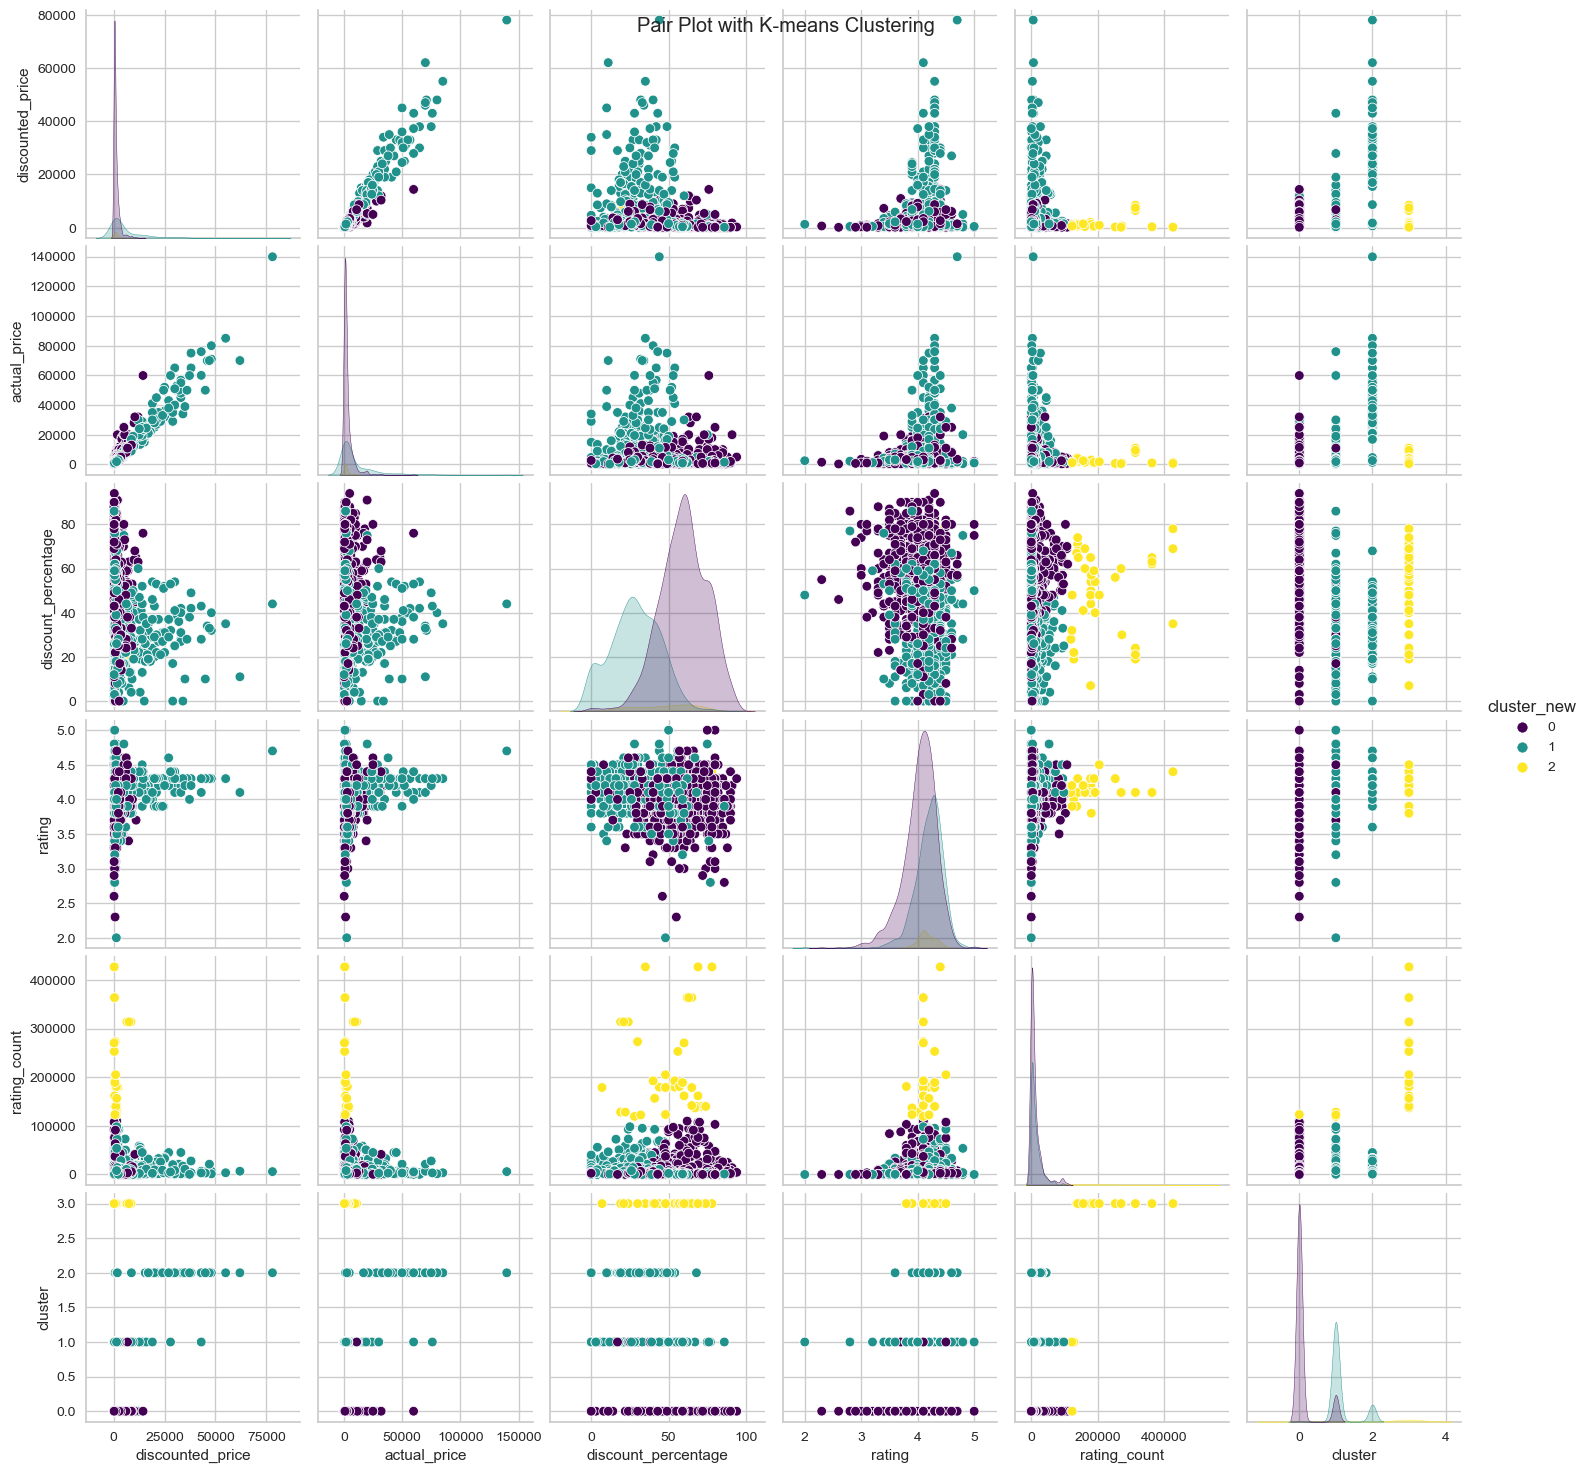

In [37]:
# Pair plot with clustering information
sns.pairplot(df_clustering_subset, hue='cluster_new', palette='viridis', markers='o', diag_kind='kde')
plt.suptitle('Pair Plot with K-means Clustering')
plt.show()

In [38]:
# Merge the clustering_dataframe with original datframe on the 'user_id' column
merged_df = pd.merge(df_clustering_subset, data, on='user_id')

In [39]:
# Group by 'product_name' and 'cluster_new', and calculate the mean for each group
grouped_df = merged_df.groupby(['product_name', 'cluster_new']).mean()

# Sort the grouped DataFrame by the specified columns in descending order
sorted_df = grouped_df.sort_values(by=['cluster_new', 'discounted_price_x', 'actual_price_x', 'discount_percentage_x', 'rating_x', 'rating_count_x'], ascending=[True, False, False, False, False, False])

# Reset index to make it easier to work with
sorted_df = sorted_df.reset_index()

# Iterate through each cluster and print the top 5 products
for cluster in sorted_df['cluster_new'].unique():
    cluster_table = sorted_df[sorted_df['cluster_new'] == cluster].head(5)[['product_name', 'discounted_price_x', 'actual_price_x', 'discount_percentage_x', 'rating_x', 'rating_count_x']]
    
    print(f"\nTop 5 products for Cluster {cluster}:\n")
    print(cluster_table)


Top 5 products for Cluster 0:

                                        product_name  discounted_price_x  \
0  Coway Professional Air Purifier for Home, Long...             14400.0   
1  TCL 80 cm (32 inches) HD Ready Certified Andro...             11990.0   
2  Sansui 80cm (32 inches) HD Ready Smart LED TV ...             10990.0   
3  TCL 80 cm (32 inches) HD Ready Certified Andro...             10901.0   
4  SanDisk 1TB Extreme Portable SSD 1050MB/s R, 1...             10389.0   

   actual_price_x  discount_percentage_x  rating_x  rating_count_x  
0         59900.0                   76.0       4.4          3837.0  
1         31990.0                   63.0       4.2            64.0  
2         19990.0                   45.0       3.7           129.0  
3         30990.0                   65.0       4.1           398.0  
4         32000.0                   68.0       4.4         41398.0  

Top 5 products for Cluster 1:

                                          product_name  discounte

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_18417/1341472016.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = merged_df.groupby(['product_name', 'cluster_new']).mean()


### Insights and Recommendations:

In [ ]:
# Cluster 0: Frequent Discount Seekers:
# The Coway Air Purifier is a standout choice for those looking for air purification, given the high discount and positive customer feedback.
# TCL Smart LED TVs are attractive for budget-conscious customers, and the fourth product has a higher rating count.
# The SanDisk Portable SSD is a top recommendation for those seeking high-capacity storage, given its significant discount, high rating, and popularity.

# Cluster 1: High-Value Shoppers
# High-End Choice: Sony Bravia 65-inch 4K Smart LED TV for premium features and a significant discount.
# OnePlus Options: Consider OnePlus 55-inch and 65-inch U Series TVs for a balance between quality and price.
# Budget-Friendly Option: MI 55-inch 5X Series 4K Smart LED TV and VU 55-inch GloLED Series for affordable choices with good features and discounts.

# Cluster 2: Premium Customers
# Budget Smartphones: Consider any of the Redmi 9A variants based on your RAM and storage requirements.
# Affordable Earbuds: The boAt Airdopes 141 offers a significant discount, making it a budget-friendly choice for wireless earbuds. However, consider the ratings for personal preferences.

## PRODUCT RECOMMENDATIONS USING COSINE SIMILIARITY

In [41]:
merged_df['about_product'] = merged_df['about_product'].fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['about_product'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [42]:
def get_cluster_recommendations(cluster, product_name):
    cluster_indices = merged_df[merged_df['cluster_new'] == cluster].index
    product_index = merged_df[(merged_df['product_name'] == product_name) & (merged_df['cluster_new'] == cluster)].index[0]
    sim_scores = list(enumerate(cosine_sim[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [i for i in sim_scores if i[0] in cluster_indices]
    sim_scores = sim_scores[1:11]
    product_indices = [i[0] for i in sim_scores]
    return merged_df['product_name'].iloc[product_indices]

In [43]:
## Top 10 Similar products in each cluster

In [44]:
# Loop through all clusters
for cluster_number in range(3): 
    print(f"\nCluster {cluster_number} Recommendations:")
    
    # Get unique product names within the current cluster
    cluster_products = merged_df[merged_df['cluster_new'] == cluster_number]['product_name'].unique()
    
    # Loop through all products in the current cluster
    for product_name in cluster_products:
        print(f"\nSimilar products for '{product_name}':")
        
        # Call the recommendation function for the current cluster and product
        cluster_recommendations = get_cluster_recommendations(cluster_number, product_name)
        
        # Print the list of similar products within the cluster
        print(cluster_recommendations)


Cluster 0 Recommendations:

Similar products for 'Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)':
6     Wayona Nylon Braided USB to Lightning Fast Cha...
7     Wayona Nylon Braided USB to Lightning Fast Cha...
8     Wayona Nylon Braided USB to Lightning Fast Cha...
14    Wayona Nylon Braided USB to Lightning Fast Cha...
15    Wayona Nylon Braided USB to Lightning Fast Cha...
16    Wayona Nylon Braided USB to Lightning Fast Cha...
22    Wayona Nylon Braided USB to Lightning Fast Cha...
23    Wayona Nylon Braided USB to Lightning Fast Cha...
24    Wayona Nylon Braided USB to Lightning Fast Cha...
30    Wayona Nylon Braided USB to Lightning Fast Cha...
Name: product_name, dtype: object

Similar products for 'Wayona Nylon Braided 3A Lightning to USB A Syncing and Fast Charging Data Cable for iPhone, Ipad (3 FT Pack of 1, Black)':
3     Wayona Nylon Braided (2 Pack) Lightnin